# Лабораторная работа № 1. 
Логистическая регрессия ­-- Задача предсказания оттока клиентов банка.

--------------------
Выполнил:\
**Маковеев Никита Владимирович**

-------------------------



In [40]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
sns.set_theme()


In [41]:
# Глобальные переменные
target_feature = 'Exited'
random_state = 97

### Знакомство с данными и их исследование

In [42]:
df = pd.read_csv('churn.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


**Признаки:**
+ RowNumber — номер строки таблицы;
+ CustomerId — идентификатор клиента;
+ Surname — фамилия клиента;
+ CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и
+озвращал их);
+ Geography — страна проживания клиента (банк межнациональный);
+ Gender — пол клиента;
+ Age — возраст клиента;
+ Tenure — сколько лет клиент пользуется банком;
+ Balance — сколько у клиента денег на счетах в банке;
+ NumOfProduct — число услуг банка, которыми воспользовался клиент;
+ HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
+ IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
+ EstimatedSalary — предполагаемая заработная плата клиента;
+ Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).


Проверяем наличие пропусков:

In [43]:
df.isnull().sum().sum()


0

In [44]:
df = df.drop(['Surname', 'CustomerId'], axis=1)
df['Gender'] = df['Gender'].map(lambda x: x=='Male')
df

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,France,False,42,2,0.00,1,1,1,101348.88,1
1,2,608,Spain,False,41,1,83807.86,1,0,1,112542.58,0
2,3,502,France,False,42,8,159660.80,3,1,0,113931.57,1
3,4,699,France,False,39,1,0.00,2,0,0,93826.63,0
4,5,850,Spain,False,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,771,France,True,39,5,0.00,2,1,0,96270.64,0
9996,9997,516,France,True,35,10,57369.61,1,1,1,101699.77,0
9997,9998,709,France,False,36,7,0.00,1,0,1,42085.58,1
9998,9999,772,Germany,True,42,3,75075.31,2,1,0,92888.52,1


Смотрим на сбалансированность классов:

<Axes: xlabel='Exited', ylabel='count'>

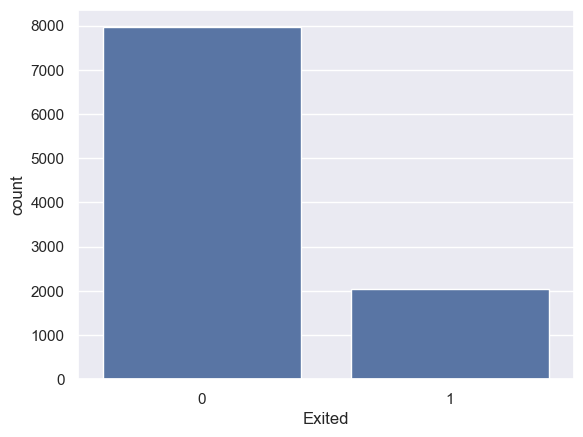

In [48]:
sns.countplot(data=df, x=target_feature)

Исследуем категориальные признаки

In [49]:
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['Geography']

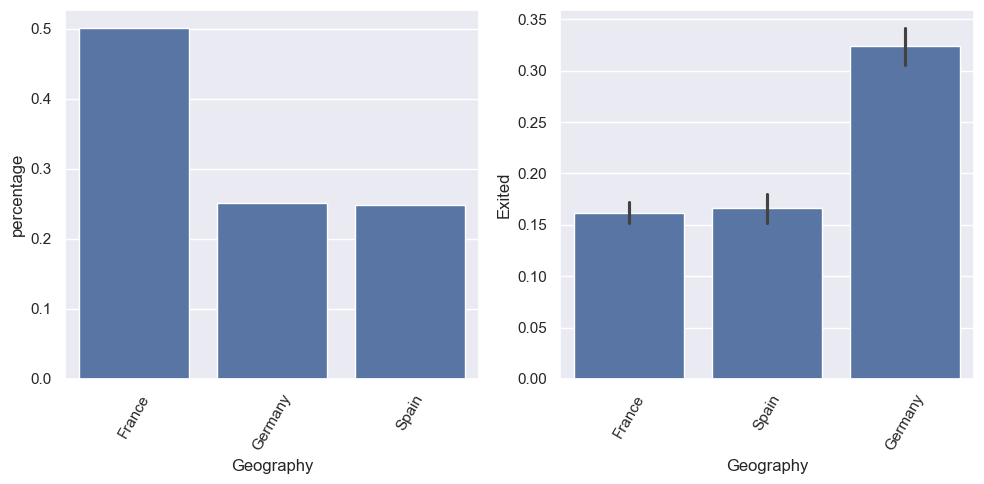

In [56]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(10, 5)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    mean_barplot = sns.barplot(data=df, x=feature, y=target_feature, ax=axes[1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Подготовка данных (предобработка)

Кодируем текстовые категориальные признаки

In [57]:
dummies_data = pd.get_dummies(df, drop_first=True)
dummies_data.head()

,RowNumber,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,1,619,False,42,2,0.00,1,1,1,101348.88,1,False,False
1,2,608,False,41,1,83807.86,1,0,1,112542.58,0,False,True
2,3,502,False,42,8,159660.80,3,1,0,113931.57,1,False,False
3,4,699,False,39,1,0.00,2,0,0,93826.63,0,False,False
4,5,850,False,43,2,125510.82,1,1,1,79084.10,0,False,True


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [58]:
X = dummies_data.drop([target_feature], axis=1)
y = dummies_data[target_feature]

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,shuffle=True, random_state = random_state, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [61]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Моделирование + оценка модели

Поиск параметров можно проводить с помощью численных методов. Например, градиентного спуска

In [62]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=random_state, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=97, solver='sag')

Выводим отчет по метрикам для тренировочной и тестовой выборок

In [65]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print("Вывод для тренировочной выборки\n",metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)

print("Вывод для тестовой выборки\n",metrics.classification_report(y_test, y_test_pred))

Вывод для тренировочной выборки
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      6370
           1       0.63      0.21      0.32      1630

    accuracy                           0.81      8000
   macro avg       0.73      0.59      0.60      8000
weighted avg       0.79      0.81      0.78      8000

Вывод для тестовой выборки
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.18      0.28       407

    accuracy                           0.81      2000
   macro avg       0.70      0.58      0.58      2000
weighted avg       0.77      0.81      0.77      2000



c:\Users\nikit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


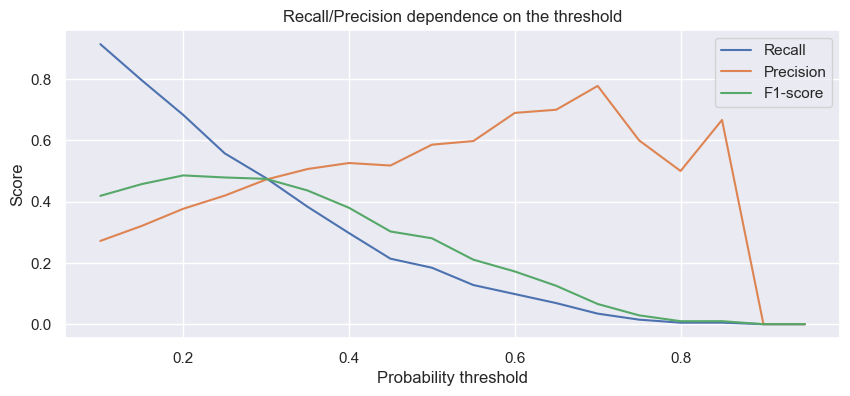

In [ ]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

In [95]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.25
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1593
           1       0.42      0.56      0.48       407

    accuracy                           0.75      2000
   macro avg       0.65      0.68      0.66      2000
weighted avg       0.78      0.75      0.77      2000



In [96]:
confusion_matrix1 = metrics.confusion_matrix(y_test, y_test_pred_opt)
confusion_matrix1

array([[1279,  314],
       [ 180,  227]], dtype=int64)

Text(117.24999999999999, 0.5, 'y true')

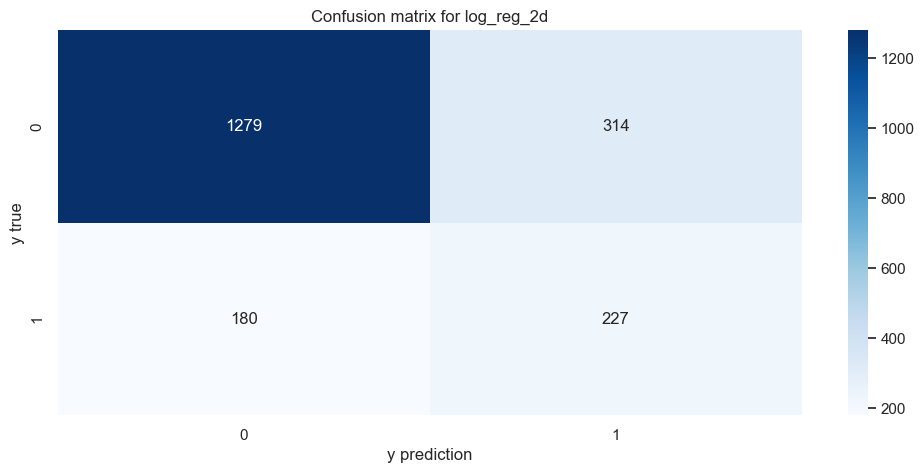

In [97]:
#Визуализируем матрицы ошибок
fig, ax = plt.subplots(figsize=(12, 5)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=ax, cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
ax.set_title('Confusion matrix for log_reg_2d')
ax.set_xlabel('y prediction')
ax.set_ylabel('y true')


## Результат.
В ходе работы были обработаны исходные данные. Было принято решение удалить столбцы с фамилиями и id номером, тк дополнительной информации они не несут. Столбец Gender был преобразован в столбец 0 и 1, где 1 - мужчина, 0 женщина. Так же использован принцип one hot encoding для признака 'Geography'. В итоге получилась модель линейной регрессии. После изучения ее результатов и метрик, было решено выбрать пороговое значения для определения класса 0.25. Это значение не обеспечивает максимум метрики accuracy, зато метрики precision и recall близки к своим максимальным значениям. Я старался максимизировать f1 метрику и метрику recall, тк нам очень важно не пропустить клиентов, которые собираются уйти из банка. На метрику accuracy я смотрел в меньшую степень, тк классы не сбалансированы, объектов 0 класса в 4 раза больше.